<a href="https://colab.research.google.com/github/dscho15/deep-learning/blob/main/Lecture9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Articles

- https://medium.com/analytics-vidhya/spam-ham-classification-using-lstm-in-pytorch-950daec94a7c

- https://github.com/sijoonlee/spam-ham-walkthrough/blob/master/walkthrough.ipynb

- https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html



# LSTM

In [1]:
import glob
from pathlib import Path
import tqdm as tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from tqdm.notebook import tqdm
from google_drive_downloader import GoogleDriveDownloader as gdd

torch.manual_seed(0)

# Email spam classifier

In [2]:
# Download data

gdd.download_file_from_google_drive('13DLnvpRhDO-D5JHCuPq85k_v-yMiMNCQ', '~/lingsmap_public-bare.zip', unzip=True)
assert Path('~/lingsmap_public-bare').exists()

  0%|          | 0/2893 [00:00<?, ?it/s]

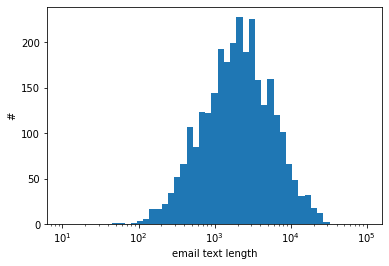

2893 emails
percentage spam: 0.17
ascii codes between 10 and 126


In [3]:
# Load data

filepaths = glob.glob('~/lingsmap_public-bare/*/*.txt')
emails = []
emails_ascii = []
targets = []

for i, filepath in enumerate(tqdm(filepaths)):
    with open(filepath) as file:
        email = file.read()
    emails.append(email)
    emails_ascii.append([ord(c) for c in email])  # convert character to ascii code
    targets.append('spmsg' in filepath)

plt.hist([len(e) for e in emails], np.logspace(1, 5))
plt.xlabel('email text length')
plt.ylabel('#')
plt.xscale('log')
plt.show()

print(f'{len(emails)} emails')
print(f'percentage spam: {np.mean(targets):.2f}')
emails_ascii_flat = np.concatenate(emails_ascii)
print(f'ascii codes between {emails_ascii_flat.min()} and {emails_ascii_flat.max()}')

So even if we just guess 'not spam' all the time, we can get 83 % correct. Lets consider this as the **baseline**.

In [4]:
# lets read few examples our loaded data
for i in range(4):
    print(f'----  Spam: {targets[i]}  ----')
    print(emails[i], '\n')

----  Spam: False  ----
Subject: grammar in schools

i 'd like to second herb stahlke 's plea , following his brief survey of the decline in grammar teaching ( which mirrors the events in uk ) . > i also teach an undergrad english linguistics course that , for many > students , is the only brush with grammar in the entire english ed . > program . i find that these students , many of them well prepared and > highly motivated , have had little or no grammar in k12 . this is not > surprising , since they were taught by teachers who were taught to > believe that the teaching of grammar served no purpose . if they were > taught it at all , little effort was made to make grammar make sense or > seem relevant and interesting . they will become teachers with > probablly less understanding of and ability to teach grammar than even > the generation before them . > > how do we reverse this ? certainly not by either replacing grammar > with even more abstract and difficulty linguistic subject matt

**Task**

* Create a class to load the dataset 
    * To be able to batch emails, they have to have the same length. You can ensure this in different ways e.g. zero-padding
    * Make a training and validation set based on *emails_ascii* and *targets*  
* Create and train a recurrent model to classify whether the emails are spam or not
    * Have a look at the [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) module and the [Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) module

In [24]:
class SpamEmailsDataset(torch.utils.data.Dataset):
    """Spam Email Dataset"""

    def __init__(self, emails, targets, transform=None):
      self.emails = emails
      self.targets = torch.tensor(targets).to(torch.float32)
      self.transform = transform

      # zero-pad the emails
      longest_len = 0
      for email in emails:
        if longest_len < len(email):
          longest_len = len(email)
      
      # zero-pad the emails:
      for i in range(len(emails)):
        len_diff = longest_len - len(emails[i])
        emails[i] += ' ' * len_diff
      
      # indice mails
      self.indices_email = torch.zeros((len(self.emails), len(self.emails[0])), dtype=torch.long)
      for i, email in enumerate(self.emails):
        self.indices_email[i] = torch.tensor(np.array(list(email)).view(np.int32).astype(np.int64))
      self.indices_email -= torch.min(self.indices_email)

    def minmax_indices(self):
      return torch.min(self.indices_email), torch.max(self.indices_email)

    def __len__(self):
      return len(self.emails)

    def __getitem__(self, idx):
      return self.indices_email[idx], self.targets[idx]

# Spam Email Dataset # very slow
spam_email_dataset = SpamEmailsDataset(emails, targets)

In [37]:
# split training data up
(train_set, valid_set, test_set) = torch.utils.data.random_split(spam_email_dataset, [2000, 200, 693])

# dataloaders
batch_size = 48
loader_train = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle=True, num_workers=2)
loader_valid = torch.utils.data.DataLoader(valid_set, batch_size = batch_size, shuffle=True, num_workers=2)
loader_test = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle=True, num_workers=2)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [38]:
class SpamMailLSTM(nn.Module):
    def __init__(self, hidden_dim, n_layers, output_size = 1, vocab_size = 112, embedding_dim = 2, drop_lstm=0.1, drop_out = 0.1):
        super().__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # Embedding 
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM layers
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_lstm, batch_first=True)
        
        # Dropout layer
        self.dropout = nn.Dropout(drop_out)
        
        # Linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, seq_lengths):

        # embeddings
        embedded_seq_tensor = self.embedding(x)
                
        # pack, remove pads
        packed_input = torch.nn.utils.rnn.pack_padded_sequence(embedded_seq_tensor, seq_lengths, batch_first=True)
        
        # lstm
        # returns a packed version of all outputs states ct's, therefore returns
        # the final output hidden state and ct
        packed_output, (ht, ct) = self.lstm(packed_input, None)

        # unpack, recover padded sequence 
        output, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        output = output[:, -1, :]
       
        # collect the last output in each batch
        # last_idxs = (input_sizes - 1).to(device) # last_idxs = input_sizes - torch.ones_like(input_sizes)
        # output = torch.gather(output, 1, last_idxs.view(-1, 1).unsqueeze(2).repeat(1, 1, self.hidden_dim)).squeeze() # [batch_size, hidden_dim]
        
        # dropout and fully-connected layer
        output = self.dropout(output)
        output = self.fc(output).squeeze()
               
        # sigmoid function
        logits = self.sig(output)
        return logits

In [40]:
# Hyperparameters:

SETTINGS = {"batch_size": batch_size,
            "embedding_dim": 2,
            "n_layers": 2,
            "hidden_dim": 128,
            "epoch": 5,
            "lr": 1e-3,
            "clip": 5}

device = torch.device("cuda")

In [41]:
spam_lstm_net = SpamMailLSTM( hidden_dim = SETTINGS["hidden_dim"], \
                              n_layers = SETTINGS["n_layers"], \
                              output_size = 1, \
                              vocab_size = 117, \
                              embedding_dim = SETTINGS["embedding_dim"] \
                             ).to(device)

opt = torch.optim.Adam(spam_lstm_net.parameters(), SETTINGS["lr"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=2)
criterion = torch.nn.BCELoss()

train_loss, valid_loss = [], []
train_accuracy, valid_accuracy = [], []

for epoch in tqdm(range(SETTINGS["epoch"])):

  # Set to training mode
  spam_lstm_net.train()

  # Parameters
  losses, accuracy = [], []

  for x, y in loader_train:
    
    # Get data pairs (input, target)
    x, y = x.to(device), y.to(device)

    # Get a sequential length
    seq_length = [x.shape[1]] * x.shape[0]

    # Returns the logits
    logits = spam_lstm_net(x, seq_length)

    # Compute the loss
    loss = criterion(logits, y)

    
    opt.zero_grad()
    loss.backward()

    # Step
    nn.utils.clip_grad_norm_(spam_lstm_net.parameters(), SETTINGS["clip"])
    opt.step()

    accuracy.append((torch.sum((logits > 0.5).to(torch.float32) == y)).detach().cpu().item())
    losses.append(loss.item())
    
  
  # Update loss
  train_loss.append(np.mean(losses))
  train_accuracy(np.mean(accuracy)/2000)
  

  # ------------------------ #

  # Set to eval mode
  spam_lstm_net.eval()

  with torch.no_grad():

    # Parameters
    losses = []

    for x, y in loader_valid:
      
      # Get data pairs (input, target)
      x, y = x.to(device), y.to(device)

      # Get a sequential length
      seq_length = [x.shape[1]] * x.shape[0]

      # Returns the logits
      logits = spam_lstm_net(x, seq_length)

      # Compute the loss
      loss = criterion(logits, y)
      opt.zero_grad()
      loss.backward()

      # Step
      nn.utils.clip_grad_norm_(spam_lstm_net.parameters(), SETTINGS["clip"])
      opt.step()
      
      accuracy.append((torch.sum((logits > 0.5).to(torch.float32) == y)).detach().cpu().item())
      losses.append(loss.item())
  
  # Update loss
  valid_loss.append(np.mean(losses))
  valid_accuracy(np.mean(accuracy)/200)

  # Step the scheduler
  scheduler.step()




  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


TypeError: ignored

# Bonus - Number sorting
Create and train a NN to sort a sequence of iid standard normally distributed numbers  
Hint: Encoder-Decoder